### G1

Generation 1, Best Function Value: -4.3325663884103776
Generation 2, Best Function Value: -6.482276385418633
Generation 3, Best Function Value: -7.800105699700108
Generation 4, Best Function Value: -8.539098809474973
Generation 5, Best Function Value: -8.564653739962582
Generation 6, Best Function Value: -9.787001688315687
Generation 7, Best Function Value: -10.04457841859239
Generation 8, Best Function Value: -10.149653667002024
Generation 9, Best Function Value: -10.292045075087515
Generation 10, Best Function Value: -10.368952905287905
Generation 11, Best Function Value: -10.487406425968834
Generation 12, Best Function Value: -10.487406425968834
Generation 13, Best Function Value: -10.487406425968834
Generation 14, Best Function Value: -10.565024993078431
Generation 15, Best Function Value: -10.565024993078431
Generation 16, Best Function Value: -10.565024993078431
Generation 17, Best Function Value: -10.565024993078431
Generation 18, Best Function Value: -10.565024993078431
Generat

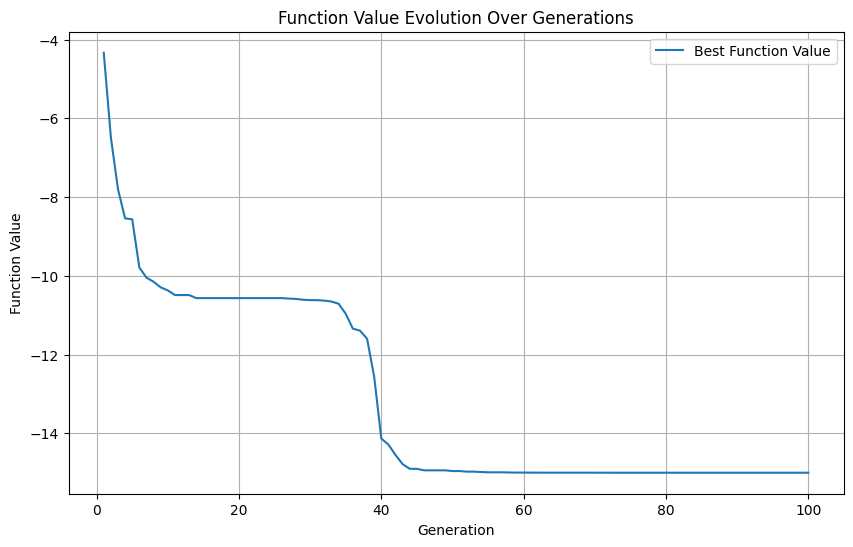

Best Solution: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.9999668712070418, 2.9999651363729427, 2.9999223760006952, 1.0]
Best Function Value: -14.99985438358068


In [118]:
import numpy as np
import random
import matplotlib.pyplot as plt

def PrG1f(x):
    x1 = x[:4]
    x2 = x[4:]
    return 5 * np.sum(x1) - 5 * np.sum(np.array(x1) ** 2) - np.sum(x2)

def PrG1c(x):
    constraints = np.zeros(35)
    constraints[0] = 2 * x[0] + 2 * x[1] + x[9] + x[10] - 10
    constraints[1] = 2 * x[0] + 2 * x[2] + x[9] + x[11] - 10
    constraints[2] = 2 * x[1] + 2 * x[2] + x[10] + x[11] - 10
    constraints[3] = -8 * x[0] + x[9]
    constraints[4] = -8 * x[1] + x[10]
    constraints[5] = -8 * x[2] + x[11]
    constraints[6] = -2 * x[3] - x[4] + x[9]
    constraints[7] = -2 * x[5] - x[6] + x[10]
    constraints[8] = -2 * x[7] - x[8] + x[11]
    for i in range(13):
        constraints[9 + i] = -x[i]
    upper_bounds = [1] * 9 + [100, 100, 100, 1]
    for i, ub in enumerate(upper_bounds):
        constraints[22 + i] = x[i] - ub
    return constraints

def function_value_with_constraints(x, function_func, constraints, penalty_weight=1e6):
    function_value = function_func(x)
    penalties = sum(max(0, c) * penalty_weight for c in constraints(x))
    return function_value + penalties

def random_population_G1(m, d):
    lower_bounds = [0] * 9 + [0, 0, 0, 0]
    upper_bounds = [1] * 9 + [100, 100, 100, 1]
    x = np.random.uniform(lower_bounds, upper_bounds, (m, d))
    sigma = np.random.uniform(0.1, 5, (m, d))
    return [x.tolist(), sigma.tolist()]

def population_evaluation(p, function_func, constraints):
    x, _ = p
    return [function_value_with_constraints(ind, function_func, constraints) for ind in x]

def parent_selection_roulette(p, l, f_vals):
    f_vals = np.array(f_vals)
    offset = abs(np.min(f_vals)) + 1e-6
    adjusted_f_vals = f_vals + offset
    inverted_vals = 1 / adjusted_f_vals
    probabilities = inverted_vals / np.sum(inverted_vals)
    indices = np.random.choice(len(f_vals), size=l, replace=True, p=probabilities)
    selected_x = [p[0][i] for i in indices]
    selected_sigma = [p[1][i] for i in indices]
    return [selected_x, selected_sigma]

def crossover(parents, crossover_rate=0.9):
    x, sigma = parents[0], parents[1]
    num_parents = len(x)
    num_children = num_parents // 2
    children_x = []
    children_sigma = []
    for _ in range(num_children):
        if random.random() < crossover_rate:
            parent1_idx, parent2_idx = random.sample(range(num_parents), 2)
            parent1_x, parent2_x = x[parent1_idx], x[parent2_idx]
            parent1_sigma, parent2_sigma = sigma[parent1_idx], sigma[parent2_idx]
            child1_x = [(p1 + p2) / 2 for p1, p2 in zip(parent1_x, parent2_x)]
            child2_x = [(p1 - p2) / 2 + random.choice([p1, p2]) for p1, p2 in zip(parent1_x, parent2_x)]
            child1_sigma = [(s1 + s2) / 2 for s1, s2 in zip(parent1_sigma, parent2_sigma)]
            child2_sigma = [(s1 - s2) / 2 + random.choice([s1, s2]) for s1, s2 in zip(parent1_sigma, parent2_sigma)]
            children_x.extend([child1_x, child2_x])
            children_sigma.extend([np.clip(child1_sigma, 1e-4, 1), np.clip(child2_sigma, 1e-4, 1)])
        else:
            parent_idx = random.randint(0, num_parents - 1)
            children_x.append(x[parent_idx])
            children_sigma.append(sigma[parent_idx])
    return [children_x, children_sigma]

def mutation(p, t, t_0, lower_bound, upper_bound):
    x, sigma = p[0], p[1]
    epsilon_0 = random.gauss(0, t_0)
    sigma = [
        [
            max(1e-4, min(1, i * np.exp(epsilon_0 + random.gauss(0, t))))
            for i in s
        ]
        for s in sigma
    ]
    x = [
        [
            np.clip(x[i][dim] + random.gauss(0, sigma[i][dim]), lower_bound[dim], upper_bound[dim])
            for dim in range(len(x[i]))
        ]
        for i in range(len(x))
    ]
    return [x, sigma]

def ES_2(m, l, t, d, t0, f,constraints, T, random_population, lower_bound, upper_bound, crossover_rate=0.9):
    p = random_population(m, d)
    f_vals = population_evaluation(p, f, constraints)
    best_solution, best_function_value = None, float('inf')
    function_value_history = []
    for generation in range(T):
        parents = parent_selection_roulette(p, l, f_vals)
        children = crossover(parents, crossover_rate)
        mutated_children = mutation(children, t, t0, lower_bound, upper_bound)
        f_vals_children = population_evaluation(mutated_children, f, constraints)
        p = mutated_children
        f_vals = f_vals_children
        current_best_function_value = min(f_vals)
        if current_best_function_value < best_function_value:
            best_function_value = current_best_function_value
            best_solution = mutated_children[0][np.argmin(f_vals)]
        function_value_history.append(best_function_value)
        print(f"Generation {generation + 1}, Best Function Value: {best_function_value}")
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, T + 1), function_value_history, label="Best Function Value")
    plt.xlabel("Generation")
    plt.ylabel("Function Value")
    plt.title("Function Value Evolution Over Generations")
    plt.legend()
    plt.grid()
    plt.show()
    return best_solution, best_function_value

lower_bounds = [0] * 9 + [0, 0, 0, 0]
upper_bounds = [1] * 9 + [100, 100, 100, 1]

best_solution, best_function_value = ES_2(
    m=200, l=8000, t=np.log(0.5), d=13, t0=np.log(1), f=PrG1f, constraints= PrG1c, T=100,
    random_population=random_population_G1,
    lower_bound=lower_bounds, upper_bound=upper_bounds
)

print("Best Solution:", best_solution)
print("Best Function Value:", best_function_value)


In [119]:
def function_value_with_constraints(x, function_func, constraints, penalty_weight=1e6):
    function_value = function_func(x)
    penalties = sum(max(0, c) * penalty_weight for c in constraints(x))
    return function_value + penalties

def population_evaluation(p, function_func, constraints):
    x, _ = p
    return [function_value_with_constraints(ind, function_func, constraints) for ind in x]


def parent_selection(p, l, f_vals):
    indices = np.argsort(f_vals)[:l]
    selected_x = [p[0][i] for i in indices]
    selected_sigma = [p[1][i] for i in indices]
    return [selected_x, selected_sigma]




def ES_1(m, l, t, d, t0, f, constraints, T, random_population, lower_bound, upper_bound):
    p = random_population(m, d)
    f_vals = population_evaluation(p, f, constraints)
    best_solution, best_function_value = None, float('inf')
    function_value_history = []

    for generation in range(T):
        p_c = parent_selection(p, l, f_vals)
        p_c_mutated = mutation(p_c, t, t0, lower_bound, upper_bound)
        combined_x = p[0] + p_c_mutated[0]
        combined_sigma = p[1] + p_c_mutated[1]
        combined_population = [combined_x, combined_sigma]
        f_vals_combined = population_evaluation(combined_population, f, constraints)
        combined_population_with_function_values = list(zip(combined_x, combined_sigma, f_vals_combined))
        combined_population_sorted = sorted(combined_population_with_function_values, key=lambda x: x[2])
        selected_combined_x = [individual[0] for individual in combined_population_sorted[:m]]
        selected_combined_sigma = [individual[1] for individual in combined_population_sorted[:m]]
        p = [selected_combined_x, selected_combined_sigma]

        for i in range(m):
            current_function_value = combined_population_sorted[i][2]
            if current_function_value < best_function_value:
                best_function_value = current_function_value
                best_solution = combined_population_sorted[i][0]

        function_value_history.append(best_function_value)

        print(f"Generation {generation + 1}, Best Function Value: {best_function_value}")

    plt.plot(range(1, T + 1), function_value_history, label="Best Function Value")
    plt.xlabel("Generation")
    plt.ylabel("Function Value")

    plt.title("Function Value Evolution Over Generations")
    plt.legend()
    plt.grid()
    plt.show()

    return best_solution, best_function_value



Generation 1, Best Function Value: 89339870.19129056
Generation 2, Best Function Value: 89339870.19129056
Generation 3, Best Function Value: 86460760.15452784
Generation 4, Best Function Value: 82084504.99403752
Generation 5, Best Function Value: 78168725.30844267
Generation 6, Best Function Value: 73009642.4505608
Generation 7, Best Function Value: 73009642.4505608
Generation 8, Best Function Value: 67907583.28977057
Generation 9, Best Function Value: 62912344.18668341
Generation 10, Best Function Value: 62912344.18668341
Generation 11, Best Function Value: 56938732.983955875
Generation 12, Best Function Value: 56938732.983955875
Generation 13, Best Function Value: 56077272.271417625
Generation 14, Best Function Value: 52039481.220026866
Generation 15, Best Function Value: 45682821.308592625
Generation 16, Best Function Value: 45682821.308592625
Generation 17, Best Function Value: 43992172.466055244
Generation 18, Best Function Value: 40897730.61960291
Generation 19, Best Function Val

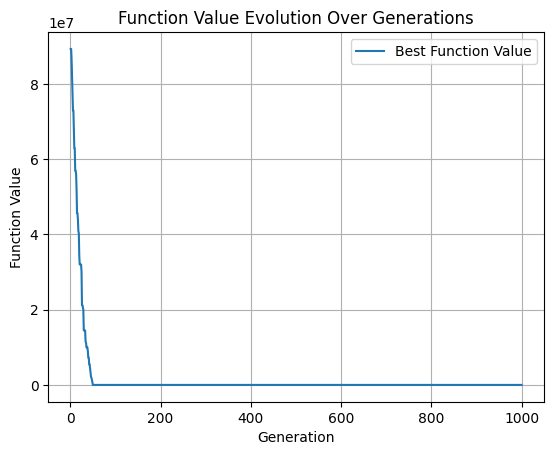

Best Solution: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999651347730376, 0.999697877789403, 2.9999484463790718, 2.999976974795808, 2.9994295547619783, 0.9998371226111448]
Best Function Value: -14.998855111110446


In [121]:

lower_bounds = [0] * 13
upper_bounds = [1] * 9 + [100, 100, 100, 1]

best_solution, best_function_value = ES_1(
    m=200, l=100, t=np.log(0.5), d=13, t0=np.log(1), f=PrG1f, constraints=PrG1c, T=1000,
    random_population=random_population_G1,
    lower_bound=lower_bounds, upper_bound=upper_bounds
)

print("Best Solution:", best_solution)
print("Best Function Value:", best_function_value)


Generation 1, Best Function Value: -0.21320495458622332
Generation 2, Best Function Value: -0.22035588725843797
Generation 3, Best Function Value: -0.22035588725843797
Generation 4, Best Function Value: -0.22035588725843797
Generation 5, Best Function Value: -0.22035588725843797
Generation 6, Best Function Value: -0.22035588725843797
Generation 7, Best Function Value: -0.22035588725843797
Generation 8, Best Function Value: -0.22035588725843797
Generation 9, Best Function Value: -0.2236130203093216
Generation 10, Best Function Value: -0.23512786180224737
Generation 11, Best Function Value: -0.237525314050133
Generation 12, Best Function Value: -0.24382390208931726
Generation 13, Best Function Value: -0.24382390208931726
Generation 14, Best Function Value: -0.24382390208931726
Generation 15, Best Function Value: -0.24382390208931726
Generation 16, Best Function Value: -0.24382390208931726
Generation 17, Best Function Value: -0.24382390208931726
Generation 18, Best Function Value: -0.2477

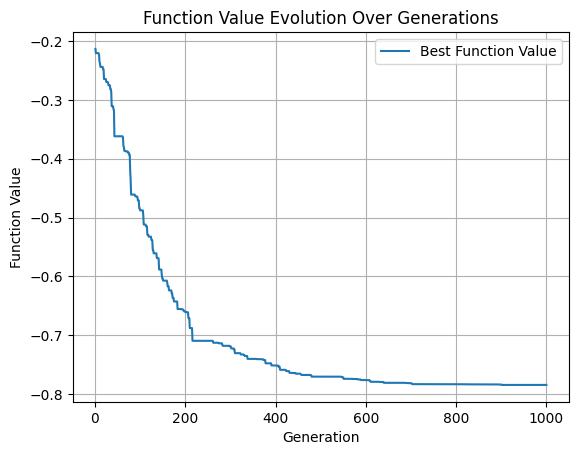

Best Solution: [6.2631967233785515, 3.0874933765777417, 3.0808129386939505, 3.0544108591844235, 3.056091344621361, 2.991578752204412, 2.9460559740463794, 0.4579189541132499, 2.913026239400294, 0.48327714554944373, 0.4136622883872828, 0.48329554651455514, 0.4165715750990451, 0.48718328571440367, 0.40934586303012305, 0.48407708426183027, 0.40580283731772293, 0.3893515532189082, 0.41795609937230427, 0.4509064569091229]
Best Function Value: -0.7846411321728521


In [123]:
def PrG2f(x):
    n = 20
    sum_jx = 0
    for j in range(n):
        sum_jx += (j + 1) * x[j]**2
    numerator = np.sum(np.cos(x)**4) - 2 * np.prod(np.cos(x)**2)
    denominator = np.sqrt(sum_jx)
    y = -abs(numerator / denominator)
    return y

def PrG2c(x):
    n = 20
    constraints = np.zeros(2 * n + 2)
    constraints[0] = -np.prod(x) + 0.75
    constraints[1] = np.sum(x) - 7.5 * n

    for j in range(n):
        constraints[j + 2] = -x[j]

    for j in range(n):
        constraints[j + n + 2] = x[j] - 10

    return constraints


def random_population_G2(m, d):
    lower_bounds = [0] * 20
    upper_bounds = [10] * 20
    x = np.random.uniform(lower_bounds, upper_bounds, (m, d))
    sigma = np.random.uniform(0.1, 1, (m, d))
    return [x.tolist(), sigma.tolist()]


lower_bounds = [0] * 20
upper_bounds = [10] * 20


best_solution, best_function_value = ES_1(
    m=2000, l=1000, t=np.log(0.2), d=20, t0=np.log(0.7), f=PrG2f, constraints=PrG2c, T=1000,
    random_population=random_population_G2,
    lower_bound=lower_bounds, upper_bound=upper_bounds
)

print("Best Solution:", best_solution)
print("Best Function Value:", best_function_value)

### G2

Generation 1, Best Function Value: -0.21042095268803718
Generation 2, Best Function Value: -0.2359770519525039
Generation 3, Best Function Value: -0.2637675337866143
Generation 4, Best Function Value: -0.26863961309481466
Generation 5, Best Function Value: -0.2765707654825167
Generation 6, Best Function Value: -0.2818095469804277
Generation 7, Best Function Value: -0.2987936344965868
Generation 8, Best Function Value: -0.30154091507631137
Generation 9, Best Function Value: -0.3026096826646314
Generation 10, Best Function Value: -0.3114202219335263
Generation 11, Best Function Value: -0.32503116955117484
Generation 12, Best Function Value: -0.38134301367538687
Generation 13, Best Function Value: -0.41957793626579637
Generation 14, Best Function Value: -0.44293852695825175
Generation 15, Best Function Value: -0.4534659031246617
Generation 16, Best Function Value: -0.4591163164099226
Generation 17, Best Function Value: -0.47617268233689586
Generation 18, Best Function Value: -0.4865063200

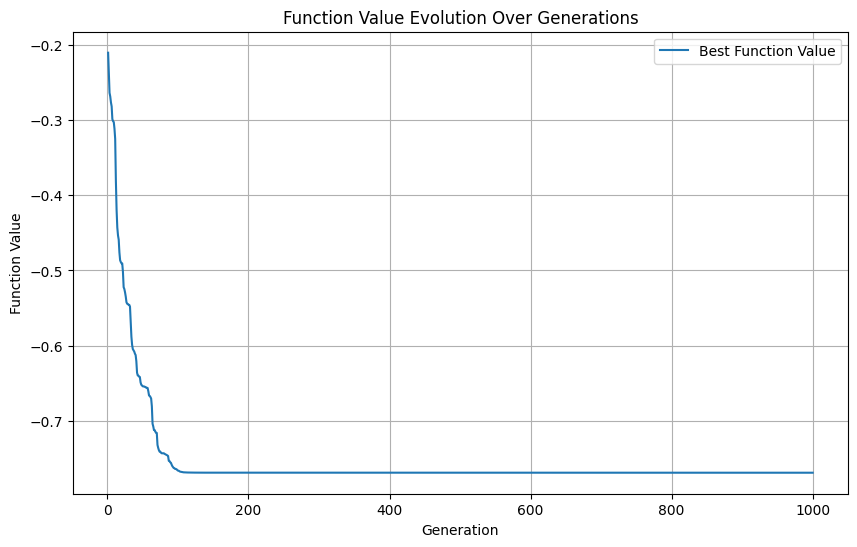

Best Solution: [3.1651365158858193, 3.1320006774490774, 3.1037077007395406, 3.073225776833878, 3.041989561429873, 3.010847253453914, 0.499142461175196, 0.4966045496347987, 2.9089688545783323, 2.873251473480847, 0.4832877279084076, 0.47617566692753005, 0.47438932572277703, 0.4606341321738673, 0.45660760715477156, 0.4578274977366321, 0.45197028055050237, 0.4478148784341056, 0.4443072547379189, 0.44217353422550576]
Best Function Value: -0.7691476795467472


In [125]:
best_solution, best_function_value = ES_2(
    m=200, l=8000, t=np.log(0.2), d=20, t0=np.log(0.7), f=PrG2f, constraints=PrG2c, T=1000,
    random_population=random_population_G2,
    lower_bound=lower_bounds, upper_bound=upper_bounds
)

print("Best Solution:", best_solution)
print("Best Function Value:", best_function_value)

### G6

Generation 1, Best Function Value: 1944226.8209223207
Generation 2, Best Function Value: 1944226.8209223207
Generation 3, Best Function Value: 1944226.8209223207
Generation 4, Best Function Value: 1944226.8209223207
Generation 5, Best Function Value: 1944226.8209223207
Generation 6, Best Function Value: -5552.215723899053
Generation 7, Best Function Value: -5552.215723899053
Generation 8, Best Function Value: -5552.215723899053
Generation 9, Best Function Value: -5552.215723899053
Generation 10, Best Function Value: -5552.215723899053
Generation 11, Best Function Value: -5552.215723899053
Generation 12, Best Function Value: -5552.215723899053
Generation 13, Best Function Value: -5552.215723899053
Generation 14, Best Function Value: -5552.215723899053
Generation 15, Best Function Value: -5552.215723899053
Generation 16, Best Function Value: -5552.215723899053
Generation 17, Best Function Value: -5552.215723899053
Generation 18, Best Function Value: -6048.484889715046
Generation 19, Best

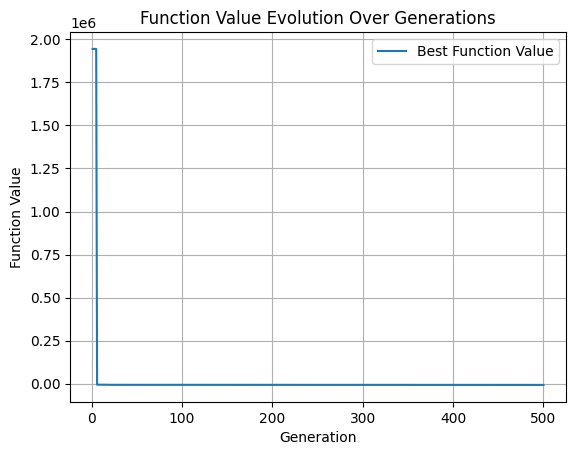

Best Solution: [14.095202213111133, 0.843380003200412]
Best Function Value: -6961.342167700982


In [78]:
def PrG6f(x):
    y = (x[0] - 10)**3 + (x[1] - 20)**3
    return y

def PrG6c(x):
    y = np.zeros(6)
    y[0] = -(x[0] - 5)**2 - (x[1] - 5)**2 + 100
    y[1] = (x[0] - 6)**2 + (x[1] - 5)**2 - 82.81

    y[2] = -x[0] + 13
    y[3] = -x[1]

    y[4] = x[0] - 100
    y[5] = x[1] - 100

    return y


def random_population_G6(m, d):
    lower_bounds = [13, 0]
    upper_bounds = [100, 100]

    x = np.random.uniform(lower_bounds, upper_bounds, (m, d))
    sigma = np.random.uniform(0.1, 1, (m, d))
    return [x.tolist(), sigma.tolist()]

lower_bounds = [13, 0]
upper_bounds = [100, 100]


best_solution, best_function_value = ES_1(
    m=3000, l=1000, t=np.log(20), d=2, t0=np.log(10), f=PrG6f, constraints=PrG6c, T=500,
    random_population=random_population_G6,
    lower_bound=lower_bounds, upper_bound=upper_bounds
)

print("Best Solution:", best_solution)
print("Best Function Value:", best_function_value)

Generation 1, Best Function Value: -1705.5026177607601
Generation 2, Best Function Value: -1785.4192648321082
Generation 3, Best Function Value: -1822.3786258135228
Generation 4, Best Function Value: -1949.5069723143818
Generation 5, Best Function Value: -2809.5511903129427
Generation 6, Best Function Value: -4297.086683104124
Generation 7, Best Function Value: -4957.058232836088
Generation 8, Best Function Value: -5345.069737110549
Generation 9, Best Function Value: -6556.479054872841
Generation 10, Best Function Value: -6685.758533351905
Generation 11, Best Function Value: -6734.229331850181
Generation 12, Best Function Value: -6763.8578645919415
Generation 13, Best Function Value: -6775.928976319463
Generation 14, Best Function Value: -6811.094442585112
Generation 15, Best Function Value: -6834.65598384729
Generation 16, Best Function Value: -6854.618977299223
Generation 17, Best Function Value: -6896.077144795077
Generation 18, Best Function Value: -6908.204616510612
Generation 19,

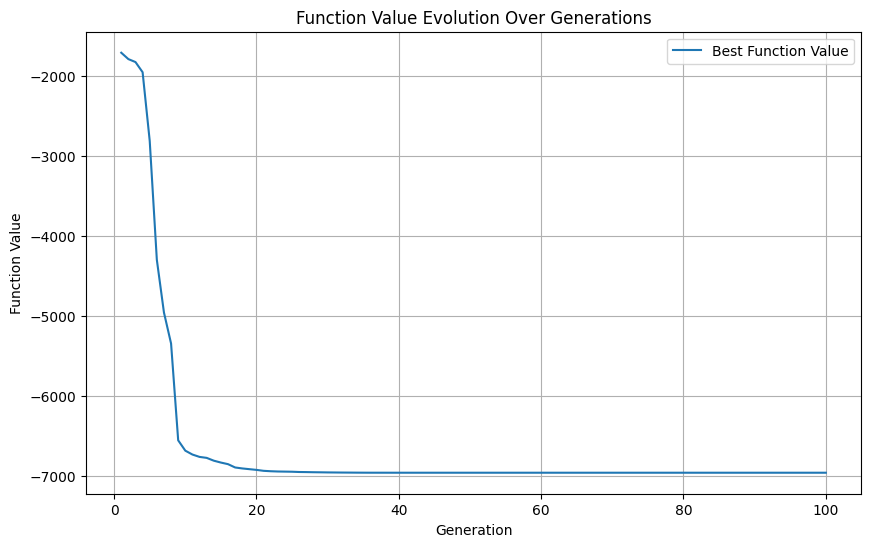

Best Solution: [14.095007151785852, 0.8429754148519188]
Best Function Value: -6961.797413325034


In [80]:
best_solution, best_function_value = ES_2(
    m=2000, l=1000, t=np.log(20), d=2, t0=np.log(10), f=PrG6f, constraints=PrG6c, T=100,
    random_population=random_population_G6,
    lower_bound=lower_bounds, upper_bound=upper_bounds
)

print("Best Solution:", best_solution)
print("Best Function Value:", best_function_value)

<ipython-input-108-2a44975810ae>:2: RuntimeWarning: invalid value encountered in scalar divide
  y = -(np.sin(2 * np.pi * x[0]) ** 3 * np.sin(2 * np.pi * x[1])) / (x[0] ** 3 * (x[0] + x[1]))


Generation 1, Best Function Value: -0.06526046145900402
Generation 2, Best Function Value: -0.06526046145900402
Generation 3, Best Function Value: -0.0869861195271572
Generation 4, Best Function Value: -0.0869861195271572
Generation 5, Best Function Value: -0.09079053528351516
Generation 6, Best Function Value: -0.09079053528351516
Generation 7, Best Function Value: -0.09079053528351516
Generation 8, Best Function Value: -0.09079053528351516
Generation 9, Best Function Value: -0.09079053528351516
Generation 10, Best Function Value: -0.09079053528351516
Generation 11, Best Function Value: -0.09079053528351516
Generation 12, Best Function Value: -0.09079053528351516
Generation 13, Best Function Value: -0.09079053528351516
Generation 14, Best Function Value: -0.09079053528351516
Generation 15, Best Function Value: -0.09079053528351516
Generation 16, Best Function Value: -0.09079053528351516
Generation 17, Best Function Value: -0.09079053528351516
Generation 18, Best Function Value: -0.090

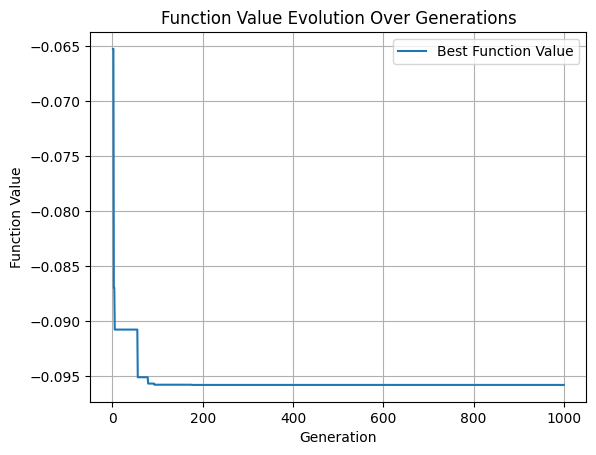

Best Solution: [1.2278951851970503, 4.244770454818911]
Best Function Value: -0.09582432094803703


In [108]:
def PrG8f(x):
    y = -(np.sin(2 * np.pi * x[0]) ** 3 * np.sin(2 * np.pi * x[1])) / (x[0] ** 3 * (x[0] + x[1]))
    return y

def PrG8c(x):
    y = np.zeros(2)

    y[0] = x[0] ** 2 - x[1] + 1
    y[1] = 1 - x[0] + (x[1] - 4) ** 2

    return y


def random_population_G8(m, d):
    lower_bounds = [0, 0]
    upper_bounds = [10, 10]

    x = np.random.uniform(lower_bounds, upper_bounds, (m, d))
    sigma = np.random.uniform(0.1, 3, (m, d))
    return [x.tolist(), sigma.tolist()]


lower_bounds = [0, 0]
upper_bounds = [10, 10]


best_solution, best_function_value = ES_1(
    m=3000, l=1000, t=np.log(0.9), d=2, t0=np.log(0.1), f=PrG8f, constraints=PrG8c, T=1000,
    random_population=random_population_G8,
    lower_bound=lower_bounds, upper_bound=upper_bounds
)


print("Best Solution:", best_solution)
print("Best Function Value:", best_function_value)

Generation 1, Best Function Value: 0.7785722004812838
Generation 2, Best Function Value: 0.7785722004812838
Generation 3, Best Function Value: 0.7785722004812838
Generation 4, Best Function Value: 0.7785722004812838
Generation 5, Best Function Value: 0.7785722004812838
Generation 6, Best Function Value: 0.7785722004812838
Generation 7, Best Function Value: 0.7785722004812838
Generation 8, Best Function Value: 0.7785722004812838
Generation 9, Best Function Value: 0.7785722004812838
Generation 10, Best Function Value: 0.7785722004812838
Generation 11, Best Function Value: 0.7785722004812838
Generation 12, Best Function Value: 0.7785722004812838
Generation 13, Best Function Value: 0.7785722004812838
Generation 14, Best Function Value: 0.770721938844749
Generation 15, Best Function Value: 0.770721938844749
Generation 16, Best Function Value: 0.770721938844749
Generation 17, Best Function Value: 0.7508161472653255
Generation 18, Best Function Value: 0.7508161472653255
Generation 19, Best Fu

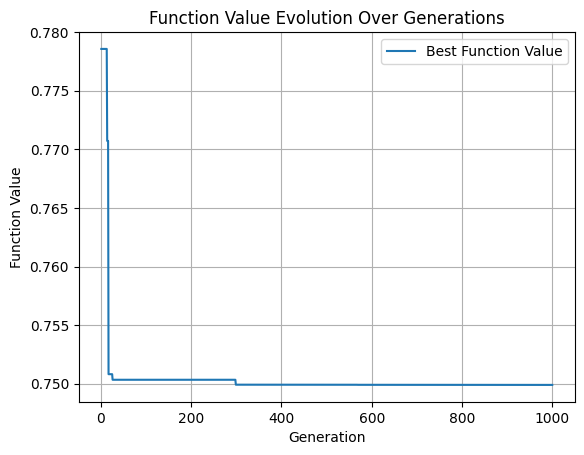

Best Solution: [0.7070577745963698, 0.5000305656666856]
Best Function Value: 0.7499001318847452


In [114]:
import numpy as np

def PrG11f(x):
    return x[0]**2 + (x[1] - 1)**2

def PrG11c(x):
    y = np.zeros(5)
    y[0] = abs(x[1] - x[0]**2) - 1e-4
    y[1] = -x[0] - 1
    y[2] = -x[1] - 1
    y[3] = x[0] - 1
    y[4] = x[1] - 1

    return y

def random_population_G11(m, d):
    lower_bounds = [-1, -1]
    upper_bounds = [1, 1]

    x = np.random.uniform(lower_bounds, upper_bounds, (m, d))
    sigma = np.random.uniform(0.1, 1, (m, d))
    return [x.tolist(), sigma.tolist()]

lower_bounds = [-1, -1]
upper_bounds = [1, 1]


best_solution, best_function_value = ES_1(
    m=3000, l=1000, t=np.log(0.9), d=2, t0=np.log(0.1), f=PrG11f, constraints=PrG11c, T=1000,
    random_population=random_population_G11,
    lower_bound=lower_bounds, upper_bound=upper_bounds
)

print("Best Solution:", best_solution)
print("Best Function Value:", best_function_value)
